### Курсовой проект от ПАО "МегаФон".


Необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

#### Данные

В качестве исходных данных доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 

В качестве входных данных представлены:

- data_train.csv: id, vas_id, buy_time, target

- features.csv.zip: id, <feature_list> 

И тестовый набор:

- data_test.csv: id, vas_id, buy_time

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 

buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция 

datetime.fromtimestamp из модуля datetime.

id - идентификатор абонента

vas_id - подключаемая услуга

#### Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

#### Формат представления результата

1. Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука. 
3. Презентация в формате .pdf, в которой необходимо отразить:
 - Информация о модели, ее параметрах, особенностях и основных результатах.
 - Обоснование выбора модели и ее сравнение с альтернативами.
 - Принцип составления индивидуальных предложений для выбранных абонентов.
Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

### Загрузка необходимых библиотек

In [43]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import date

import itertools

import sys

import pickle

import logging

from pathlib2 import Path

import xgboost as xgb

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import warnings
warnings.filterwarnings('ignore')

### Загрузка наборов данных

In [2]:
path = Path('G:')

In [3]:
train = pd.read_csv(path.joinpath('data_train.csv')).drop(['Unnamed: 0'], axis=1)

train.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [4]:
test = pd.read_csv(path.joinpath('data_test.csv')).drop(['Unnamed: 0'], axis=1)

test.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


In [5]:
features = pd.read_csv(path.joinpath('features.csv'), sep='\t').drop(['Unnamed: 0'], axis=1)

features.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


#### Оптимизация объема занимаемой памяти

In [6]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Объем до оптимизации {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Объем памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Объем сократился на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train = reduce_mem_usage(train)

Объем до оптимизации 25.38 MB
Объем памяти после оптимизации: 12.69 MB
Объем сократился на 50.0%


In [8]:
test = reduce_mem_usage(test)

Объем до оптимизации 1.63 MB
Объем памяти после оптимизации: 0.82 MB
Объем сократился на 50.0%


In [9]:
features = reduce_mem_usage(features)

Объем до оптимизации 8779.10 MB
Объем памяти после оптимизации: 4389.55 MB
Объем сократился на 50.0%


#### Преобразуем признаки 'buy_time' из типа int к временному ряду.

In [10]:
train['buy_time'] = train['buy_time'].apply(lambda data: date.fromtimestamp(data))

train.head()

,id,vas_id,buy_time,target
0,540968,8.0,2018-09-17,0.0
1,1454121,4.0,2018-07-16,0.0
2,2458816,1.0,2018-08-13,0.0
3,3535012,5.0,2018-09-03,0.0
4,1693214,1.0,2018-09-03,0.0


In [11]:
test['buy_time'] = test['buy_time'].apply(lambda data: date.fromtimestamp(data))

test.head()

,id,vas_id,buy_time
0,3130519,2.0,2019-01-21
1,2000860,4.0,2019-01-21
2,1099444,2.0,2019-01-07
3,1343255,5.0,2019-01-14
4,1277040,2.0,2019-01-07


In [12]:
features['buy_time'] = features['buy_time'].apply(lambda data: date.fromtimestamp(data))

features.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-16,18.910028,46.980888,4.969214,-1.386798,3.791754,-14.011789,-16.08618,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-301.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0
1,2014722,2018-10-15,36.690029,152.400894,448.069214,563.833191,463.841766,568.998230,-16.08618,-53.216099,...,-891.373840,-544.770813,-20.996269,48.369553,80.252274,-13.832889,-0.694429,-1.175933,-0.456140,0.0
2,2015199,2018-12-24,-67.019974,157.050888,-63.180786,178.103195,-68.598244,156.998215,3.51382,25.183903,...,-977.373840,-613.770813,-12.996268,-37.630447,10829.251953,-25.832888,-0.694429,-12.175933,-0.456140,0.0
3,2021765,2018-08-13,7.010029,150.200882,-6.930786,216.213196,76.621758,351.848206,-16.08618,-65.076096,...,-973.373840,-613.770813,-23.996269,-37.630447,-205.747726,-24.832888,-0.694429,-11.175933,-0.456140,1.0
4,2027465,2018-08-06,-90.439972,134.220886,-104.380783,153.643204,-109.798248,132.538208,-16.08618,-65.076096,...,1643.626099,2007.229248,206.003738,-21.630449,6667.252441,92.167114,-0.694429,49.824066,47.543861,0.0


### Разведочный анализ данных

#### Проверим наличие пропусков

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int32  
 1   vas_id    831653 non-null  float32
 2   buy_time  831653 non-null  object 
 3   target    831653 non-null  float32
dtypes: float32(2), int32(1), object(1)
memory usage: 15.9+ MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int32  
 1   vas_id    71231 non-null  float32
 2   buy_time  71231 non-null  object 
dtypes: float32(1), int32(1), object(1)
memory usage: 1.1+ MB


In [15]:
features.isnull().values.any()

False

Датасеты не содержат незаполненных значений.

#### Исследуем распределения в датасетах

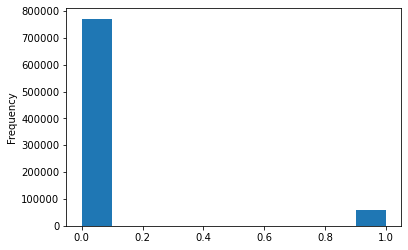

In [16]:
train['target'].plot(kind='hist',bins=10);

Наблюдается дисбаланс распределения переменной 'target'

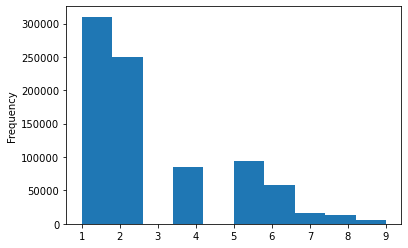

In [17]:
train['vas_id'].plot(kind='hist',bins=10);

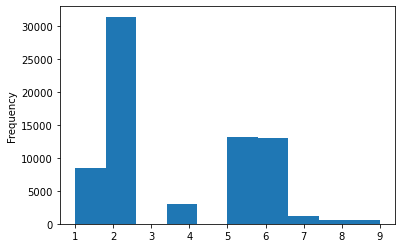

In [18]:
test['vas_id'].plot(kind='hist',bins=10);

Распределение подключенных услуг (параметр 'vas_id') на тренировочном и тестовом наборах отличаются

#### Определим временные периоды в датасетах

In [19]:
np.min(train['buy_time'])

datetime.date(2018, 7, 9)

In [20]:
np.max(train['buy_time'])

datetime.date(2018, 12, 31)

Временной период для тренировочного набора составляет 09.07.2018- 31.12.2018 гг

In [21]:
np.min(test['buy_time'])

datetime.date(2019, 1, 7)

In [22]:
np.max(test['buy_time'])

datetime.date(2019, 1, 21)

Временной период для тестового набора составляет 07.01.2019- 21.01.2019 гг

#### Построим матрицу корреляций

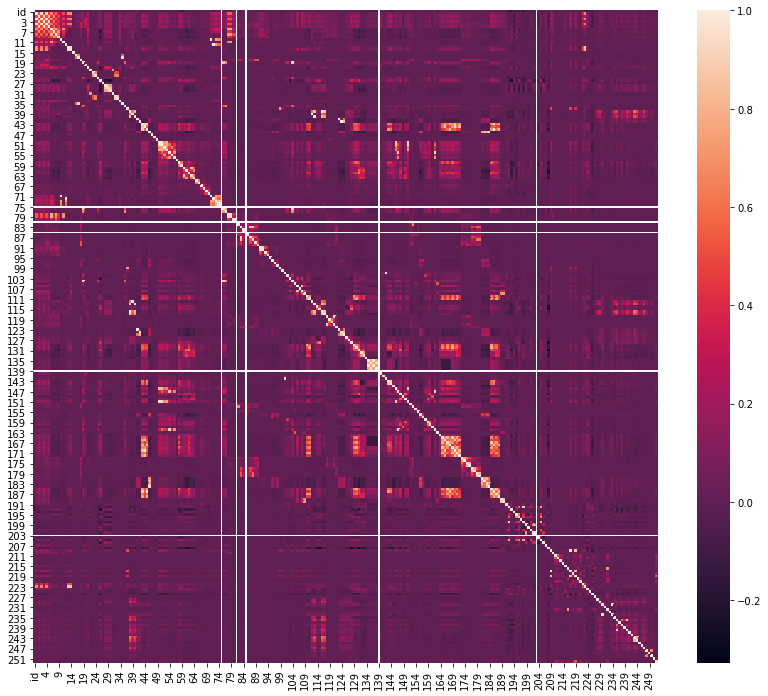

In [23]:
plt, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(features.corr(),ax=ax);

Согласно тепловой карте, признаки 75, 81, 85, 139, 203 не содержат значений, а следовательно могут быть исключены из дальнейших расчетов

In [24]:
features[['75', '81', '85', '139', '203']].describe()

,75,81,85,139,203
count,4512528.0,4512528.0,4512528.0,4512528.0,4512528.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [25]:
features.drop(['75', '81', '85', '139', '203'], axis=1, inplace=True)

#### Проверим датасеты на наличие дубликатов

In [26]:
train.duplicated(subset=['id']).value_counts()

False    806613
True      25040
dtype: int64

In [27]:
test.duplicated(subset=['id']).value_counts()

False    70152
True      1079
dtype: int64

In [28]:
features.duplicated(subset=['id']).value_counts()

False    4362739
True      149789
dtype: int64

In [29]:
ids = train["id"]
train[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,vas_id,buy_time,target
14042,342,2.0,2018-11-19,1.0
14041,342,1.0,2018-11-05,0.0
19825,492,6.0,2018-12-17,1.0
19824,492,4.0,2018-10-08,0.0
22908,579,4.0,2018-11-19,1.0
...,...,...,...,...
751154,4339012,2.0,2018-11-19,1.0
248700,4347691,4.0,2018-11-26,0.0
248701,4347691,6.0,2018-11-19,1.0
366175,4350615,2.0,2018-12-10,1.0


### Сохранение датасетов

In [30]:
train.to_pickle(path.joinpath('train.pkl'))

test.to_pickle(path.joinpath('test.pkl'))

features.to_pickle(path.joinpath('features.pkl'))

#### Чтение ранее сохраненных наборов данных

In [31]:
train = pd.read_pickle(path.joinpath('train.pkl'))

test = pd.read_pickle(path.joinpath('test.pkl'))

features = pd.read_pickle(path.joinpath('features.pkl'))

### Проведем исследование повторяющихся id

In [32]:
ids = train["id"]
train[ids.isin(ids[ids.duplicated()])].sort_values('id').head(10)

,id,vas_id,buy_time,target
14042,342,2.0,2018-11-19,1.0
14041,342,1.0,2018-11-05,0.0
19825,492,6.0,2018-12-17,1.0
19824,492,4.0,2018-10-08,0.0
22908,579,4.0,2018-11-19,1.0
22909,579,6.0,2018-12-31,0.0
23753,610,8.0,2018-08-27,0.0
23754,610,8.0,2018-11-19,1.0
26111,665,6.0,2018-11-26,1.0
26110,665,2.0,2018-12-10,0.0


In [33]:
ids = test["id"]
test[ids.isin(ids[ids.duplicated()])].sort_values('id').head(10)

,id,vas_id,buy_time
552,274,4.0,2019-01-21
551,274,2.0,2019-01-14
10677,4770,4.0,2019-01-14
10676,4770,2.0,2019-01-21
20241,8166,1.0,2019-01-07
20242,8166,6.0,2019-01-21
25062,9775,6.0,2019-01-14
25061,9775,2.0,2019-01-07
40336,15522,2.0,2019-01-07
40337,15522,6.0,2019-01-14


In [34]:
ids = features["id"]
features[ids.isin(ids[ids.duplicated()])].sort_values('id').head(10) 

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
3790832,46,2018-10-15,-96.799973,-408.179108,-81.080788,-426.886810,-75.908249,-435.281799,-16.086180,-65.076096,...,13177.625977,3432.229248,-20.996269,-32.630447,-34.747723,-4.832889,-0.694429,-4.175933,-0.45614,0.0
702950,46,2018-08-27,-96.799973,15.550888,-110.740784,49.363201,-116.158249,28.258211,-16.086180,-65.076096,...,813.626160,-174.770798,-24.996269,-31.630449,-92.747726,-13.832889,-0.694429,-0.175933,-0.45614,0.0
1276326,63,2018-11-19,34.410030,204.150894,20.469213,232.073196,15.051754,210.968216,-16.086180,-59.146095,...,-313.373840,-266.770782,-25.996269,-8.630448,790.252258,-23.832888,-0.694429,-12.175933,-0.45614,0.0
1027878,63,2018-07-23,504.740021,1330.840942,519.619202,1388.833252,514.201782,1367.728149,532.213806,1201.013916,...,-943.373840,-613.770813,-25.996269,-26.630449,106.252274,-25.832888,-0.694429,-12.175933,-0.45614,0.0
2944225,71,2018-09-24,-79.009972,-390.389099,-92.950783,-404.846802,-98.368248,-425.951782,-6.766180,-55.756096,...,-851.373840,-492.770782,-25.996269,-37.630447,-285.747711,-20.832888,-0.694429,-7.175933,-0.45614,0.0
100527,71,2018-09-17,-96.799973,-408.179108,-102.260788,-414.156799,-107.678246,-435.261780,-16.086180,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-296.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
3193002,82,2018-12-31,80.290031,-34.929111,99.679214,79.253204,94.261757,58.148209,-9.416180,114.893906,...,-975.373840,-613.770813,-25.996269,-37.630447,-275.747711,-24.832888,-0.694429,-12.175933,-0.45614,0.0
4048200,82,2018-12-17,-96.799973,-204.789108,-75.150787,-204.016800,-80.568245,-225.121796,-16.086180,-65.076096,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
3555510,86,2018-08-13,49.150028,10.390888,63.159214,11.993202,57.741753,-9.111790,72.883820,125.573906,...,-950.373840,-593.770813,-24.996269,-37.630447,81.252274,-4.832889,-0.694429,8.824067,-0.45614,1.0
4499749,86,2018-09-10,-91.209969,113.100891,-96.670784,87.623199,-102.088249,66.518211,-16.086180,11.183903,...,-18.373846,338.229218,-25.996269,-18.630449,-253.747726,-22.832888,-0.694429,-9.175933,-0.45614,0.0


In [35]:
features['id'].value_counts().sort_values(ascending=False)

1979418    2
952143     2
3665143    2
306509     2
133051     2
          ..
3025411    1
3021317    1
3017223    1
3168717    1
2889499    1
Name: id, Length: 4362739, dtype: int64

Количество дубликатов не превышает двух, следовательно клиенту предлагали не больше двух услуг. Это позволяет произвести объединение датасетов.

### Объединение датасетов

Проведем объединение датасетов таким образом, чтобы id сопадали, а строки из датасета features брались с ближайшей датой.

In [36]:
train = pd.merge_asof(train.sort_values(by=['id']), 
                       features.sort_values(by=['id']), 
                       on='id', 
                       by='buy_time', 
                       direction='nearest')

train

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2,2.0,2018-12-24,0.0,-96.799973,229.530884,-110.740784,305.723206,-116.158249,284.618225,...,2300.626221,1492.229248,-21.996269,-35.630447,368.252289,11.167111,7.305572,-12.175933,-0.45614,0.0
1,4,1.0,2018-08-06,0.0,-52.309971,-225.139114,-66.250786,-258.246796,-71.668243,-279.351776,...,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
2,15,1.0,2018-08-13,0.0,49.150028,10.390888,63.159214,11.993202,57.741753,-9.111790,...,-950.373840,-593.770813,-24.996269,-37.630447,81.252274,-4.832889,-0.694429,8.824067,-0.45614,1.0
3,16,2.0,2018-10-29,0.0,42.570030,138.740891,28.629213,86.133202,23.211754,65.028214,...,1394.626099,1272.229248,-22.996269,-36.630447,-6.747724,-23.832888,-0.694429,-12.175933,-0.45614,0.0
4,29,1.0,2018-08-06,0.0,-52.309971,-225.139114,-66.250786,-258.246796,-71.668243,-279.351776,...,-977.373840,-613.770813,-25.996269,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,4362634,1.0,2018-12-31,0.0,-93.749969,-66.149109,-105.190788,-107.776794,-110.608246,-128.881790,...,-974.373840,-610.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0
831649,4362640,2.0,2018-12-31,0.0,-93.749969,-66.149109,-105.190788,-107.776794,-110.608246,-128.881790,...,-974.373840,-610.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0
831650,4362647,6.0,2018-12-31,0.0,-93.749969,-66.149109,-105.190788,-107.776794,-110.608246,-128.881790,...,-974.373840,-610.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0
831651,4362684,5.0,2018-12-24,0.0,-96.799973,-408.179108,-110.740784,-460.786804,-116.158249,-481.891785,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0


### Построение модели XGBoost

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
     train.drop(['target', 'buy_time'], axis=1),
     train['target'], test_size=0.25, shuffle=True,random_state=42)


print("X_train.shape = {} rows, {} cols".format(*X_train.shape))
print("X_test.shape = {} rows, {} cols".format(*X_test.shape))

X_train.shape = 623739 rows, 250 cols
X_test.shape = 207914 rows, 250 cols


In [38]:
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "seed": 42,
        'use_label_encoder': False
    }

model = xgb.XGBClassifier(**params)

model.fit(X_train, y_train.astype(int))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [39]:
train_pred = model.predict(X_train)

test_pred = model.predict(X_test)

In [40]:
train_pred

array([0, 0, 0, ..., 0, 0, 0])

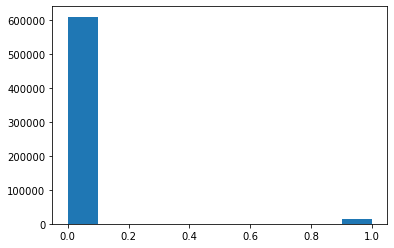

In [44]:
plt.hist(train_pred);

In [45]:
train_score = f1_score(y_train, train_pred, average='macro')
test_score = f1_score(y_test, test_pred, average='macro')

print(f"Train-score: {round(train_score, 5)}, Test-score: {round(test_score, 5)}")

Train-score: 0.65951, Test-score: 0.61011


### Проведем Cross-Validation

In [46]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
   
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [47]:
def f1_score_macro(true, pred):
    return f1_score(true, pred.astype(int), average='macro')

In [48]:
cv_strategy = KFold(n_splits=10)
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "seed": 42,
        'use_label_encoder': False
    }

model = xgb.XGBClassifier(**params)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train.drop(['target', 'buy_time'], axis=1), 
    train['target'],
    model, 
    metric=f1_score_macro, 
    cv_strategy=cv_strategy
)

Fold: 1, train-observations = 748487, valid-observations = 83166
train-score = 0.6466, valid-score = 0.6636
Fold: 2, train-observations = 748487, valid-observations = 83166
train-score = 0.6488, valid-score = 0.647
Fold: 3, train-observations = 748487, valid-observations = 83166
train-score = 0.6513, valid-score = 0.6469
Fold: 4, train-observations = 748488, valid-observations = 83165
train-score = 0.6556, valid-score = 0.6156
Fold: 5, train-observations = 748488, valid-observations = 83165
train-score = 0.6564, valid-score = 0.6027
Fold: 6, train-observations = 748488, valid-observations = 83165
train-score = 0.6559, valid-score = 0.5754
Fold: 7, train-observations = 748488, valid-observations = 83165
train-score = 0.6572, valid-score = 0.5614
Fold: 8, train-observations = 748488, valid-observations = 83165
train-score = 0.661, valid-score = 0.5511
Fold: 9, train-observations = 748488, valid-observations = 83165
train-score = 0.6559, valid-score = 0.5369
Fold: 10, train-observations =

### Сохраним обученную модель

In [49]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Сформируем индивидуальные предсказания

In [50]:
offer = pd.DataFrame(test.drop(['buy_time'], axis=1))

model.predict_proba(offer)[:,1]

array([0.01653998, 0.27758604, 0.02578748, ..., 0.0201769 , 0.01700379,
       0.02578748], dtype=float32)

In [51]:
offer_predict = pd.DataFrame(test['id'].copy())


for i in [1, 2, 4, 5, 6, 7, 8, 9]:
    offer = pd.DataFrame(test['id'].copy())
    offer['vas_id'] = i
    offer_predict[i] = model.predict_proba(offer)[:,1]
offer_predict['max prob offer'] = offer_predict.iloc[:, 1:-1].max(axis = 1)
offer_predict['vas_id offer'] = offer_predict.iloc[:, 1:-1].idxmax(axis = 1)
offer_predict

,id,1,2,4,5,6,7,8,9,max prob offer,vas_id offer
0,3130519,0.016540,0.016540,0.246312,0.016663,0.419953,0.012009,0.017036,0.118751,0.419953,6
1,2000860,0.020177,0.020177,0.277586,0.020815,0.426566,0.014163,0.020074,0.137701,0.426566,6
2,1099444,0.025787,0.025787,0.298950,0.025904,0.451273,0.015134,0.024468,0.173812,0.451273,6
3,1343255,0.025787,0.025787,0.298950,0.024603,0.445902,0.015134,0.021441,0.155248,0.445902,6
4,1277040,0.025787,0.025787,0.298950,0.025904,0.445902,0.015134,0.021441,0.155248,0.445902,6
...,...,...,...,...,...,...,...,...,...,...,...
71226,2502453,0.017004,0.017004,0.245212,0.019126,0.428058,0.014249,0.020195,0.138427,0.428058,6
71227,1693213,0.020177,0.020177,0.277586,0.021072,0.432233,0.014163,0.020074,0.137701,0.432233,6
71228,1891350,0.020177,0.020177,0.277586,0.020815,0.432233,0.014163,0.020074,0.137701,0.432233,6
71229,2437172,0.017004,0.017004,0.245212,0.019126,0.428058,0.014249,0.020195,0.138427,0.428058,6


#### Распределение услуг, рекомендованных к подключению

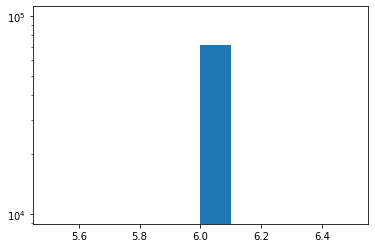

In [52]:
plt.hist(offer_predict['vas_id offer'], log=True);

In [53]:
offer_predict['vas_id offer'].value_counts()

6    71231
Name: vas_id offer, dtype: int64

Всем абонентам будет предложена услуга № 6

#### Распределение вероятностей подключения услуг 

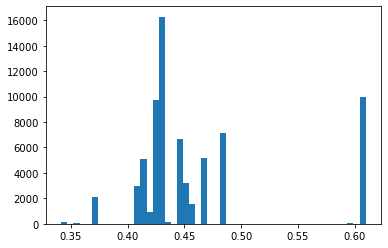

In [54]:
plt.hist(offer_predict['max prob offer'], bins=50);

### Сохраним рекомендации в файл 'offer.csv'

In [55]:
offer_predict[['id', 'vas_id offer']].to_csv('offer.csv', index=False)